In [1]:
%load_ext autoreload
%autoreload 2

from pandas import read_excel
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import timeit

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from modAL.models import ActiveLearner
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cross_decomposition import PLSRegression

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem,DataStructs,Draw,PandasTools,Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger

from IPython.display import Image

# Configure the logging - RDKit is rather verbose..
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
# Set the molecule representation to be SVG 
PandasTools.molRepresentation='svg'
# Loading and standardization method for SMILES -> RDKit molecule object
uncharger = rdMolStandardize.Uncharger()


# Loading and standardization method for SMILES -> RDKit molecule object
uncharger = rdMolStandardize.Uncharger()

import functions as fun

In [2]:
# Loading data sets
specs = pd.read_csv('/home/jovyan/covid-data/SPECS_ready_POLINA.csv')
sss_batchA = pd.read_csv('/home/jovyan/covid-data/COVID_BatchA_ready_POLINA.csv')

#Creating final dataset
data = pd.merge(specs[['ID_library', 'smiles']], sss_batchA[['ID_covid', 'Intensity_MeanIntensity_illumMITO_cells.1','Labels']], 
                left_on= 'ID_library', right_on='ID_covid', how='left')
data = data.drop(['ID_covid'],axis=1)
data.head() 

ID_library                                             smiles  \
0  CBK000155  C[C@H](Cc1ccc(OCC([O-])=O)cc1)NC[C@H](O)c1cccc...   
1  CBK000156            CC(C)(C)NCC(O)COc1cccc2[nH]c(=O)[nH]c12   
2  CBK000161  [H][C@@](CC)(NC(C)C)[C@]([H])(O)c1ccc(O)c2[nH]...   
3  CBK000162         CC(C)N[C@@H](C)[C@@H](O)COc1ccc(C)c2CCCc12   
4  CBK000164                  CC(C)NCC(O)COc1ccc(COCCOC(C)C)cc1   

   Intensity_MeanIntensity_illumMITO_cells.1  Labels  
0                                   0.010426       0  
1                                   0.009417       0  
2                                   0.008106       0  
3                                   0.010586       0  
4                                   0.010333       0

In [3]:
# First we need to parse the SMILES and create RDKit 'molecule' objects 
# the 'standardize' function was the one we defined in the first cell with code in this file
data['MOL'] = data['smiles'].apply(fun.standardize)
data.head()

### There is a problem with some of the smiles as they return none when trying to convert to molecule. 
### The next step is to fix those cases which may be a product of a typo. 

# Looking for None values
corrupted_smiles_idx_list = data[data['MOL'].isnull()].index.tolist() #finding None values
data[data['MOL'].isnull()].head(5)

ID_library                                             smiles  \
5164  CBK310016  Cc1nc2c(c(Cl)c(Cl)cc2n1Cc1ccc(cc1)B12OC(=O)CN1...   

      Intensity_MeanIntensity_illumMITO_cells.1  Labels   MOL  
5164                                   0.009946       0  None

In [4]:
data = data.drop([5164])
print(f"There are {len(data)} rows in data")

There are 5171 rows in data


In [5]:
data[data['MOL'].isnull()]

Empty DataFrame
Columns: [ID_library, smiles, Intensity_MeanIntensity_illumMITO_cells.1, Labels, MOL]
Index: []

### We can go back to reality 

In [6]:
data = data.drop(['MOL'],axis=1)

#Creating molecue objects again
data['MOL'] = data['smiles'].apply(fun.standardize)
data.head()

ID_library                                             smiles  \
0  CBK000155  C[C@H](Cc1ccc(OCC([O-])=O)cc1)NC[C@H](O)c1cccc...   
1  CBK000156            CC(C)(C)NCC(O)COc1cccc2[nH]c(=O)[nH]c12   
2  CBK000161  [H][C@@](CC)(NC(C)C)[C@]([H])(O)c1ccc(O)c2[nH]...   
3  CBK000162         CC(C)N[C@@H](C)[C@@H](O)COc1ccc(C)c2CCCc12   
4  CBK000164                  CC(C)NCC(O)COc1ccc(COCCOC(C)C)cc1   

   Intensity_MeanIntensity_illumMITO_cells.1  Labels  \
0                                   0.010426       0   
1                                   0.009417       0   
2                                   0.008106       0   
3                                   0.010586       0   
4                                   0.010333       0   

                                                 MOL  
0  <svg xmlns="http://www.w3.org/2000/svg" xmlns:...  
1  <svg xmlns="http://www.w3.org/2000/svg" xmlns:...  
2  <svg xmlns="http://www.w3.org/2000/svg" xmlns:...  
3  <svg xmlns="http://www.w3.org/2000/svg" xmlns:...  
4  <svg xmlns="http://www.w3.org/2000/svg" xmlns:...

In [7]:
# Check if any of the SMILES contain multiple fragments - 
# this can sometimes cause issues when computing descriptors
data['FRAGS'] =  data['MOL'].apply(lambda mol: len(Chem.GetMolFrags(mol,asMols=True)))
print("Fragments: {0}".format(data['FRAGS'].nunique()))

Fragments: 1


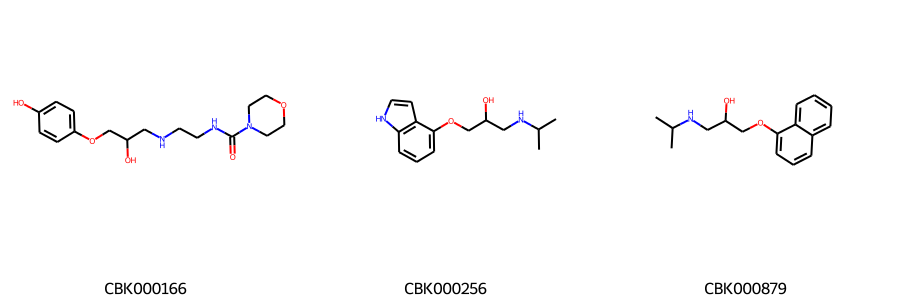

In [8]:
# Compute the descriptors that we're interested in
data['LOGP'] = data['MOL'].apply(lambda mol: Descriptors.MolLogP(mol))
data['HAC'] = data['MOL'].apply(lambda mol: Descriptors.HeavyAtomCount(mol))

# Plot
#plt.figure(figsize=(8,6))
#data.plot.scatter(x='LOGP', y='HAC')
#plt.show()
PandasTools.FrameToGridImage(data[5:8], column='MOL', legendsCol='ID_library', molsPerRow=3, subImgSize=(300, 300))

In [9]:
file_namn = r'/home/jovyan/covid-data/BatchA_for_training.csv'
#data.to_csv(file_namn, sep=',', encoding='utf-8',index=False)

### Training starts!

Parameters and Sets initialization

In [10]:
# Parameters for features
morgan_radius = 2
morgan_n_bits = 1024
fp_n_bits = 2048

# Feature creation
X_morgan, X_rdkit, y = fun.feature_creation(morgan_radius, morgan_n_bits, fp_n_bits, data)

In [18]:
# Parameters for ML model
train_size = 0.3
test_size = 0.3
n_neighbours = 3

# Parameters for AL
#N_QUERIES = 1

# split dataset into train(5 %), test(25 %), unlabel(70 %)
x_train, y_train, x_test, y_test, x_pool, y_pool = fun.split(x_dataset = X_morgan, y_dataset = y, 
                                                             ini_train_size = train_size, test_size = test_size)

In [ ]:
# Specify our core estimator along with it's active learning model.
knn_1 = KNeighborsClassifier(n_neighbors = n_neighbours)
learner_1 = ActiveLearner(estimator=knn_1, X_training = x_train, y_training = y_train)

Plain supervised machine learning

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner_1.predict(x_test) #test the learner in the complete dataset
is_correct = (predictions == y_test) #check its performance

# Record our learner's score on the raw data.
unqueried_score = learner_1.score(x_test, y_test)
print(f' Score without AL: {unqueried_score}')

Now we introduce AL

In [ ]:
#Timer
tic=timeit.default_timer()

#Train
prfmc_his, cf_mat_his, learner_1 = fun.active_learnig_train(n_queries = N_QUERIES, x_train = x_train, y_train = y_train, 
                                               x_test = x_test, y_test = y_test, x_pool = x_pool, 
                                               y_pool = y_pool, Classifier = knn_1)

toc=timeit.default_timer()
print(f'\n\nElapsed time: {toc-tic} seconds')

In [ ]:
#Plot
name = fun.plot_name_generator('knn7', train_size, test_size, 'uncsamp')
fun.plot_incremental_accuracy(prfmc_his, save = True, figure_name = name)
fun.plot_cf_mat(matrix = cf_mat_his[-1], save = True, figure_name = name)
plt.show()

# Moving on to model comparison

In [12]:
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Specify our core estimator along with it's active learning model.
knn = KNeighborsClassifier(n_neighbors = n_neighbours)
lrg = LogisticRegression(random_state=0)
rf = RandomForestClassifier(max_depth=3, random_state=0)


In [15]:
int(len(x_pool)/3)

844

In [19]:
# Parameters for AL
N_QUERIES = int(len(x_pool)/3)

#Timer
tic=timeit.default_timer()

cf_mat_x_clssifr = []
prfmc_x_classifr = []
Classifiers = [knn, lrg, rf]
for classifier in Classifiers:
    
    print(f'Training with {str(classifier)}')
    
    prfmc_his, cf_mat_his, learner= fun.active_learnig_train(n_queries = N_QUERIES, x_train = x_train, y_train = y_train, 
                                               x_test = x_test, y_test = y_test, x_pool = x_pool, 
                                               y_pool = y_pool, Classifier = classifier)
    prfmc_x_classifr.append(prfmc_his)
    cf_mat_x_clssifr.append(cf_mat_his)
    
    #Saving model
    filename = "".join(["/home/jovyan/Thesis_ActLearn_DOP_2022/main/active_learning/default_models/", str(classifier),'.sav'])
    pickle.dump(learner, open(filename, 'wb'))
    
toc=timeit.default_timer()
print(f'\n\nElapsed time: {toc-tic} seconds')

Training with KNeighborsClassifier(n_neighbors=3)
Accuracy after query 1: 0.9903
Accuracy after query 31: 0.9890
Accuracy after query 61: 0.9897
Accuracy after query 91: 0.9897
Accuracy after query 121: 0.9897
Accuracy after query 151: 0.9897
Accuracy after query 181: 0.9897
Accuracy after query 211: 0.9897
Accuracy after query 241: 0.9897
Accuracy after query 271: 0.9897
Accuracy after query 301: 0.9897
Accuracy after query 331: 0.9897
Accuracy after query 361: 0.9897
Accuracy after query 391: 0.9897
Accuracy after query 421: 0.9897
Accuracy after query 451: 0.9897
Accuracy after query 481: 0.9897
Accuracy after query 511: 0.9897
Accuracy after query 541: 0.9897
Accuracy after query 571: 0.9897
Accuracy after query 601: 0.9897
Accuracy after query 631: 0.9897
Accuracy after query 661: 0.9897
Accuracy after query 691: 0.9897
Accuracy after query 721: 0.9897
Accuracy after query 751: 0.9897
Accuracy after query 781: 0.9897
Accuracy after query 811: 0.9897
Accuracy after query 841: 0.989

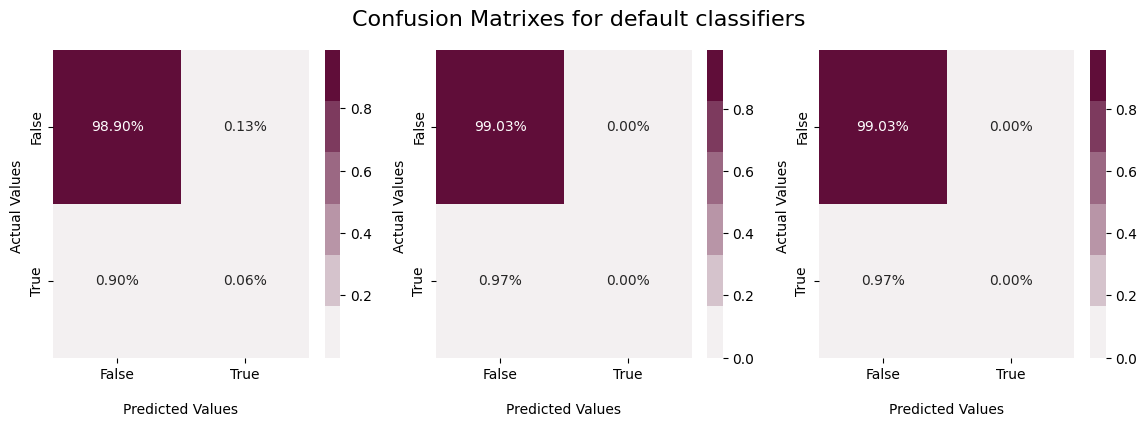

In [20]:
#Plot
fig, axes = plt.subplots(1, 3, figsize=(14,4))
i = 0
for row in axes:
    fun.plot_cf_mat(matrix = cf_mat_x_clssifr[i][-1], save = False, figure_name = None, ax=row)
    i+=1
fig.suptitle('Confusion Matrixes for default classifiers', fontsize=16)
plt.show()

In [30]:
full_data_BatchA = pd.DataFrame(X_morgan)
full_data_BatchA['Label'] = y
full_data_BatchA.head()

0  1  2  3  4  5  6  7  8  9  ...  1015  1016  1017  1018  1019  1020  \
0  0  1  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
1  0  1  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
2  0  1  0  0  1  0  0  0  0  0  ...     0     0     0     0     0     0   
3  1  1  0  0  1  0  0  0  0  0  ...     0     0     0     0     0     0   
4  0  1  0  0  1  0  0  0  0  0  ...     0     0     0     1     0     0   

   1021  1022  1023  Label  
0     0     0     0      0  
1     0     0     0      0  
2     0     0     0      0  
3     0     0     0      0  
4     0     0     0      0  

[5 rows x 1025 columns]

In [ ]:
#name = r'/home/jovyan/Thesis_ActLearn_DOP_2022/main/active_learning/data/full_data_BatchA.csv'
#full_data_BatchA.to_csv(name, sep=',', encoding='utf-8',index=False)